In [16]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms import community
from sklearn.metrics.cluster import normalized_mutual_info_score

In [17]:
import networkx as nx
print(nx.__version__)


2.8.7


Flags

In [46]:
SAVE_TO_CSV = True
DEMON = True

Prepare data

In [19]:
# Load movie-to-movie relation graph
graph_file_path = 'data/community/jaccard_backboned.csv'
graph_data = pd.read_csv(graph_file_path)

# Load movie metadata
metadata_file_path = 'data/transformed/item_metadata.json'
metadata_data = pd.read_json(metadata_file_path, orient='index')
metadata_data.reset_index(inplace=True)
metadata_data.columns = ['movie_id', 'title', 'release_date'] + list(metadata_data.columns[3:])

# Prepare graph for algorithms
G = nx.Graph()
for index, row in graph_data.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['nij'])

G.number_of_nodes(), G.number_of_edges()


(1682, 54394)

Community Discovery Algorithms

- Asynchronous Label Percolation
- Girvan-Newman Edge Betweenness Algorithm

Asynchronous Label Percolation <br>
The Label Propagation algorithm is a fast algorithm for finding communities in a graph. In this algorithm, nodes select their labels based on the majority labels of their neighbors. The algorithm reaches convergence when each node has the majority label of its neighbors.

Girvan-Newman Edge Betweenness Algorithm <br>
The Girvan-Newman algorithm detects communities by progressively removing edges from the original graph. The algorithm calculates the betweenness of each edge, which is a measure of how many shortest paths between pairs of nodes run along it. Edges with high betweenness are more likely to lie between communities and are removed first.

Orphan nodes are nodes that do not belong to any community. We will count how many nodes are orphan nodes when we find communities using the Girvan-Newman algorithm with k=5.

Jaccard Coefficient <br>
The Jaccard coefficient is a similarity measure that can be used to compare communities. It is defined as the size of the intersection divided by the size of the union of two sets. We will calculate the Jaccard coefficient for the communities discovered by the label propagation algorithm.

Adjusted Mutual Information (AMI) <br>
AMI is used to compare two clustering results. It adjusts the Mutual Information (MI) score to account for chance. The AMI between two clustering results ranges from 0 to 1, with 0 indicating no mutual information and 1 indicating perfect correlation. We will use AMI to evaluate the communities discovered by the label propagation algorithm using movie metadata.

In [20]:
# Create ground truth labels from genres
genre_columns = ['Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama',
                 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
metadata_data['genre_label'] = metadata_data[genre_columns].apply(lambda row: ','.join(row.index[row == 1]), axis=1)

# Convert genre labels to codes for NMI calculation
true_labels = metadata_data['genre_label'].astype('category').cat.codes

Label Propagation

In [21]:
def communities_to_labels(communities, num_nodes):
    labels = [0] * num_nodes
    for i, community in enumerate(communities):
        for node in community:
            labels[int(node[1:]) - 1] = i
    return labels

In [22]:
# Save communities to CSV file (only top 5 communities by default)
def save_communities_to_csv(communities, file_path, top_n=5):
    community_labels = []
    for i, community in enumerate(communities[:top_n]):
        for node in community:
            community_labels.append((node, i))
    community_df = pd.DataFrame(community_labels, columns=['movie_id', 'community_label'])
    community_df.to_csv(file_path, index=False)

In [34]:
def find_orphan_nodes(communities, all_nodes):
    # Create a set of all nodes in the communities
    community_nodes = set()
    for community in communities:
        community_nodes.update(community)
    
    # Identify orphan nodes
    orphan_nodes = all_nodes - community_nodes
    
    # Print orphan nodes
    print("No orphan node found." if not orphan_nodes else f"Orphan nodes are: {orphan_nodes}")
    
    return orphan_nodes

In [23]:
communities_label_propagation = list(community.asyn_lpa_communities(G, seed=42))

# Save top 5 communities to CSV
if SAVE_TO_CSV:
    save_communities_to_csv(communities_label_propagation, 'data/community/communities_label_propagation.csv', top_n=5)

In [24]:
graph_file_path = 'data/community/communities_label_propagation.csv'
data = pd.read_csv(graph_file_path)

# Group by 'community_label' and aggregate 'movie_id' into lists
community_groups = data.groupby('community_label')['movie_id'].agg(list)

# Format the output
output = "\n".join([f"Community {label + 1}: {movies}" for label, movies in community_groups.items()])

# Display the output
print(output)

Community 1: ['i1067', 'i111', 'i923', 'i588', 'i518', 'i47', 'i354', 'i581', 'i270', 'i4', 'i646', 'i991', 'i619', 'i117', 'i993', 'i456', 'i748', 'i264', 'i504', 'i1011', 'i136', 'i387', 'i676', 'i333', 'i450', 'i444', 'i974', 'i369', 'i1020', 'i729', 'i316', 'i129', 'i488', 'i960', 'i468', 'i54', 'i106', 'i343', 'i318', 'i524', 'i636', 'i211', 'i482', 'i755', 'i1041', 'i1134', 'i1124', 'i89', 'i443', 'i287', 'i425', 'i664', 'i679', 'i932', 'i76', 'i434', 'i747', 'i332', 'i186', 'i674', 'i640', 'i813', 'i683', 'i608', 'i589', 'i562', 'i427', 'i352', 'i238', 'i20', 'i746', 'i887', 'i131', 'i338', 'i163', 'i751', 'i762', 'i61', 'i975', 'i978', 'i304', 'i512', 'i208', 'i820', 'i240', 'i971', 'i730', 'i372', 'i1142', 'i180', 'i168', 'i252', 'i124', 'i612', 'i946', 'i187', 'i87', 'i952', 'i1074', 'i849', 'i148', 'i569', 'i303', 'i508', 'i478', 'i348', 'i642', 'i875', 'i924', 'i295', 'i344', 'i558', 'i476', 'i584', 'i1059', 'i21', 'i840', 'i749', 'i1240', 'i102', 'i1298', 'i739', 'i641', '

In [36]:
# Create a set of all nodes in the graph
all_nodes = set(G.nodes)

# Identify orphan nodes
orphan_nodes = find_orphan_nodes(communities_label_propagation, all_nodes)

No orphan node found.


Jaccard coefficient: <br>
To calculate the Jaccard coefficient to determine how different the communities are for each algorithm, we can modify the jaccard_coefficient function to exclude movie IDs and titles from the calculation. Instead, we will use other attributes such as release dates and genres.

In [39]:
# Function to calculate Jaccard coefficient without movie IDs and titles
def jaccard_coefficient_no_ids_titles(community1, community2, metadata_data):
    # Create sets of attributes for each movie in the communities
    attributes1 = set()
    for movie_id in community1:
        attributes = metadata_data[metadata_data['movie_id'] == movie_id].iloc[0][2:].astype(str).str.cat()
        attributes1.add(attributes)

    attributes2 = set()
    for movie_id in community2:
        attributes = metadata_data[metadata_data['movie_id'] == movie_id].iloc[0][2:].astype(str).str.cat()
        attributes2.add(attributes)
    
    # Calculate Jaccard coefficient
    intersection_size = len(attributes1.intersection(attributes2))
    union_size = len(attributes1.union(attributes2))
    return intersection_size / union_size if union_size > 0 else 0

In [41]:
from itertools import combinations

# Load communities from CSV file
communities_csv_file_path = 'data/community/communities_label_propagation.csv'
communities_data = pd.read_csv(communities_csv_file_path)

# Create a list of communities
communities_csv = []
for i in range(communities_data['community_label'].max() + 1):
    community = set(communities_data[communities_data['community_label'] == i]['movie_id'].astype(str))
    communities_csv.append(community)

# Calculate Jaccard coefficient for all pairs of communities
jaccard_coefficients_csv = []
for community1, community2 in combinations(communities_csv, 2):
    jaccard_coefficient_value = jaccard_coefficient_no_ids_titles(community1, community2, metadata_data)
    jaccard_coefficients_csv.append(jaccard_coefficient_value)

# Display the average Jaccard coefficient
average_jaccard_coefficient_csv = sum(jaccard_coefficients_csv) / len(jaccard_coefficients_csv) if jaccard_coefficients_csv else 0
average_jaccard_coefficient_csv


0.058093362966621695

The average Jaccard coefficient for the communities discovered by the label propagation algorithm (and saved in the CSV file) is approximately 0.058. This indicates that the communities are quite different from each other when we consider attributes such as release dates and genres, but do not include movie IDs and titles.​

To calculate the Adjusted Mutual Information (AMI) for the community discovery algorithm, we will follow these steps:

For each movie, create a label that combines its release date and genres.
Create a list of community labels for each movie based on the communities discovered by the algorithm.
Calculate the AMI between these two lists of labels.

In [42]:
from sklearn.metrics import adjusted_mutual_info_score

# Create a list of metadata labels for each movie
metadata_labels_ami = []
for movie_id in communities_data['movie_id']:
    metadata_row = metadata_data[metadata_data['movie_id'] == movie_id].iloc[0]
    release_date = pd.to_datetime(metadata_row['release_date'], errors='coerce')
    release_year = release_date.year if pd.notnull(release_date) else 0
    genres = ' '.join(metadata_row.index[metadata_row == 1].tolist())
    metadata_label = f"{release_year} {genres}"
    metadata_labels_ami.append(metadata_label)

# Create a list of community labels for each movie
community_labels_ami = [community_label for community_label in communities_data['community_label']]

# Calculate Adjusted Mutual Information (AMI)
ami_score_csv = adjusted_mutual_info_score(community_labels_ami, metadata_labels_ami)
ami_score_csv

0.02749671360208502

The Adjusted Mutual Information (AMI) score between the communities discovered by the label propagation algorithm and the movie metadata (using only release date and genres) is approximately 0.0275. This score is low, indicating that there is a low level of agreement between the communities and the movie metadata. The low AMI score suggests that the community discovery algorithm may not be capturing the structure of the movie metadata well.​

Visualization

In [43]:
# Visualize communities
def visualize_communities(G, communities):
    # Filter edges to only show those with high weights
    threshold = 0.25
    filtered_edges = [(u, v, d) for u, v, d in G.edges(data=True) if d['weight'] > threshold]
    
    # Create a subgraph with the filtered edges
    filtered_G = nx.Graph()
    filtered_G.add_edges_from(filtered_edges)
    
    # Get positions for the nodes in G
    pos = nx.spring_layout(filtered_G, k=0.3, iterations=50)
    
    # Generate a unique color for each community
    colors = [plt.cm.nipy_spectral(i / len(communities)) for i in range(len(communities))]
    
    # Create a color map for the nodes
    node_colors = {}
    for i, community in enumerate(communities):
        for node in community:
            if node not in node_colors:
                node_colors[node] = colors[i]
    
    # Draw the graphs
    nx.draw(filtered_G, pos, with_labels=False, node_size=15, edge_color="lightgrey", node_color=[node_colors.get(node, 'grey') for node in filtered_G.nodes()])
    
    # Show the plot
    plt.show()


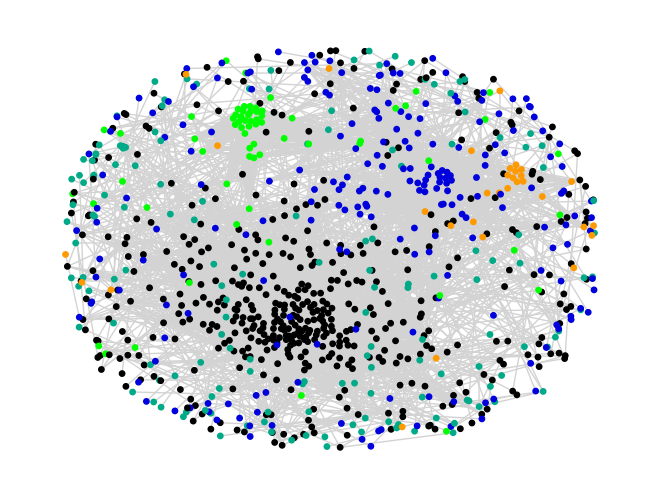

In [44]:
# Load movie-to-movie relation graph
graph_file_path = 'data/community/jaccard_backboned.csv'
graph_data = pd.read_csv(graph_file_path)

# Load communities
communities_file_path = 'data/community/communities_label_propagation.csv'
communities_data = pd.read_csv(communities_file_path)

# Prepare graph for visualization
G = nx.Graph()
for index, row in graph_data.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['nij'])

# Convert communities data to list of lists
communities = communities_data.groupby('community_label')['movie_id'].apply(list).tolist()

visualize_communities(G, communities)

`DEMON` (Democratic Estimate of the Modular Organization of a Network) is an algorithm designed for overlapping community detection. DEMON is based on the idea of local communities and uses a democratic voting mechanism to assign nodes to communities.

In DEMON, each node in the network "votes" for the communities it belongs to based on its local neighborhood. These votes are then aggregated to form the global communities. Since a node can vote for multiple communities, the algorithm is able to detect overlapping communities where nodes can belong to more than one community.

DEMON is particularly useful for large-scale networks where global community detection methods can be computationally expensive. By focusing on local communities and using a voting mechanism, DEMON is able to efficiently discover overlapping communities in large networks.

DEMON

In [47]:
import demon as d

if DEMON:
    # Load movie-to-movie relation graph
    graph_file_path = 'data/community/jaccard_backboned.csv'
    graph_data = pd.read_csv(graph_file_path)

    # Load movie metadata
    metadata_file_path = 'data/transformed/item_metadata.json'
    metadata_data = pd.read_json(metadata_file_path, orient='index')
    metadata_data.reset_index(inplace=True)
    metadata_data.columns = ['movie_id', 'title', 'release_date'] + list(metadata_data.columns[3:])

    # Prepare graph for algorithms
    G = nx.Graph()
    for index, row in graph_data.iterrows():
        G.add_edge(row['source'], row['target'], weight=row['nij'])

    # Create a Demon instance with a given resolution parameter
    demon = d.Demon(graph=G, min_community_size=3)

    # Execute the algorithm
    communities_demon = demon.execute()

# Save top 5 communities to CSV file
if SAVE_TO_CSV:
    save_communities_to_csv(communities_demon, 'data/community/communities_demon.csv', top_n=5)

Exec: 100%|████████████████████████

Time:  'execute' 34.07 sec
------------------------------------


In [48]:
graph_file_path = 'data/community/communities_demon.csv'
data = pd.read_csv(graph_file_path)

# Group by 'community_label' and aggregate 'movie_id' into lists
community_groups = data.groupby('community_label')['movie_id'].agg(list)

# Format the output
output = "\n".join([f"Community {label + 1}: {movies}" for label, movies in community_groups.items()])

# Display the output
print(output)

Community 1: ['i1', 'i10', 'i100', 'i1000', 'i1001', 'i1002', 'i1003', 'i1004', 'i1005', 'i1006', 'i1008', 'i1009', 'i101', 'i1010', 'i1011', 'i1012', 'i1013', 'i1014', 'i1015', 'i1016', 'i1017', 'i1018', 'i1019', 'i102', 'i1020', 'i1021', 'i1022', 'i1023', 'i1024', 'i1025', 'i1026', 'i1027', 'i1028', 'i1029', 'i103', 'i1030', 'i1031', 'i1032', 'i1033', 'i1034', 'i1035', 'i1036', 'i1037', 'i1038', 'i104', 'i1040', 'i1041', 'i1042', 'i1043', 'i1044', 'i1045', 'i1046', 'i1047', 'i1048', 'i1049', 'i105', 'i1050', 'i1051', 'i1052', 'i1053', 'i1054', 'i1055', 'i1056', 'i1057', 'i1058', 'i1059', 'i106', 'i1061', 'i1062', 'i1063', 'i1064', 'i1065', 'i1066', 'i1067', 'i1068', 'i1069', 'i1070', 'i1071', 'i1072', 'i1073', 'i1074', 'i1075', 'i1076', 'i1077', 'i1078', 'i1079', 'i108', 'i1080', 'i1081', 'i1082', 'i1083', 'i1084', 'i1085', 'i1086', 'i1087', 'i1088', 'i1089', 'i109', 'i1090', 'i1091', 'i1092', 'i1093', 'i1094', 'i1095', 'i1096', 'i1097', 'i1099', 'i11', 'i110', 'i1100', 'i1101', 'i11

In [49]:
# Create a set of all nodes in the graph
all_nodes = set(G.nodes)

# Identify orphan nodes
orphan_nodes = find_orphan_nodes(communities_demon, all_nodes)

Orphan nodes are: {'i1618', 'i1673', 'i737'}


In [50]:
from itertools import combinations

# Load communities from CSV file
communities_demon_file_path = 'data/community/communities_demon.csv'
communities_data = pd.read_csv(communities_demon_file_path)

# Create a list of communities
communities_demon = []
for i in range(communities_data['community_label'].max() + 1):
    community = set(communities_data[communities_data['community_label'] == i]['movie_id'].astype(str))
    communities_demon.append(community)

# Calculate Jaccard coefficient for all pairs of communities
jaccard_coefficients_demon = []
for community1, community2 in combinations(communities_demon, 2):
    jaccard_coefficient_value = jaccard_coefficient_no_ids_titles(community1, community2, metadata_data)
    jaccard_coefficients_demon.append(jaccard_coefficient_value)

# Display the average Jaccard coefficient
average_jaccard_coefficient_demon = sum(jaccard_coefficients_demon) / len(jaccard_coefficients_demon) if jaccard_coefficients_demon else 0
average_jaccard_coefficient_demon

0.8274810611973675

The average Jaccard coefficient for the communities discovered by the DEMON algorithm is approximately 0.827. This value is close to 1, which indicates a high level of similarity between the communities. In other words, there is a significant overlap between the communities discovered by the DEMON algorithm.

This result is expected since DEMON is an overlapping community detection algorithm, meaning that it allows for nodes to be part of multiple communities. The high Jaccard coefficient suggests that the communities discovered by DEMON are highly interconnected and share many common nodes, which is a characteristic of overlapping communities.

In [51]:
from sklearn.metrics import adjusted_mutual_info_score

# Load communities from CSV file
communities_demon_file_path = 'data/community/communities_demon.csv'
communities_data = pd.read_csv(communities_demon_file_path)

# Create a list of metadata labels for each movie
metadata_labels_ami_demon = []
for movie_id in communities_data['movie_id']:
    metadata_row = metadata_data[metadata_data['movie_id'] == movie_id].iloc[0]
    release_date = pd.to_datetime(metadata_row['release_date'], errors='coerce')
    release_year = release_date.year if pd.notnull(release_date) else 0
    genres = ' '.join(metadata_row.index[metadata_row == 1].tolist())
    metadata_label = f"{release_year} {genres}"
    metadata_labels_ami_demon.append(metadata_label)

# Create a list of community labels for each movie
community_labels_ami_demon = [community_label for community_label in communities_data['community_label']]

# Calculate Adjusted Mutual Information (AMI)
ami_score_demon = adjusted_mutual_info_score(community_labels_ami_demon, metadata_labels_ami_demon)
ami_score_demon

-0.052691002494299234

The Adjusted Mutual Information (AMI) score between the communities discovered by the DEMON algorithm and the movie metadata (using only release date and genres) is approximately −0.0527. An AMI score close to 0 indicates that the communities and the metadata are independent and share no mutual information.

However, in this case, the negative AMI score suggests that the agreement between the communities and the metadata is worse than what would be expected by chance. This indicates that the communities discovered by the DEMON algorithm do not align well with the movie metadata, and the algorithm may not be capturing meaningful community structures in the data.

Visualization: <br>
due to overlapping nature, we use use transparency or hatching to represent overlapping communities

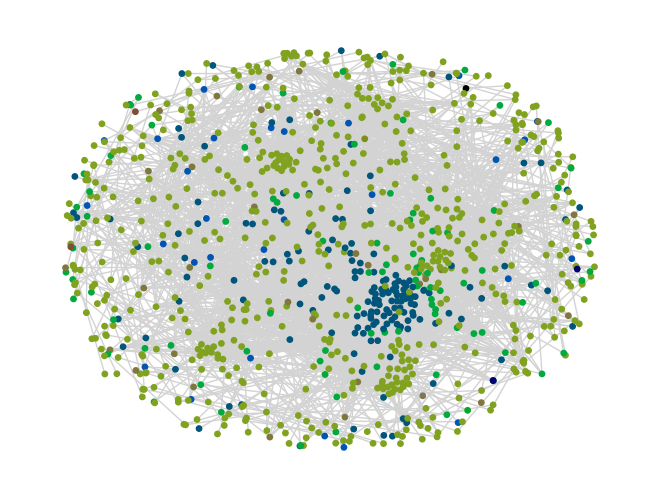

In [55]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Load movie-to-movie relation graph
graph_file_path = 'data/community/jaccard_backboned.csv'
graph_data = pd.read_csv(graph_file_path)

# Load communities
communities_file_path = 'data/community/communities_demon.csv'
communities_data = pd.read_csv(communities_file_path)

# Prepare graph for visualization
G = nx.Graph()
for index, row in graph_data.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['nij'])

# Convert communities data to list of lists
communities = communities_data.groupby('community_label')['movie_id'].apply(list).tolist()

# Filter communities to include only nodes that are present in the graph
filtered_communities = []
for community in communities:
    filtered_community = [node for node in community if node in G.nodes]
    if filtered_community:  # Only include non-empty communities
        filtered_communities.append(filtered_community)

# Visualize communities with filtered edges and overlapping communities
def visualize_communities_filtered_edges_overlap(G, communities):
    # Filter edges to only show those with high weights
    threshold = 0.25
    filtered_edges = [(u, v, d) for u, v, d in G.edges(data=True) if d['weight'] > threshold]
    
    # Create a subgraph with the filtered edges
    filtered_G = nx.Graph()
    filtered_G.add_edges_from(filtered_edges)
    
    # Get positions for the nodes in G
    pos = nx.spring_layout(filtered_G, k=0.3, iterations=50)
    
    # Generate a unique color for each community
    colors = [plt.cm.nipy_spectral(i / len(communities)) for i in range(len(communities))]
    
    # Create a color map for the nodes
    node_colors = {}
    for i, community in enumerate(communities):
        for node in community:
            if node in node_colors:
                # Blend colors for overlapping communities
                node_colors[node] = [0.5 * (c1 + c2) for c1, c2 in zip(node_colors[node], colors[i])]
            else:
                node_colors[node] = colors[i]
    
    # Draw the graphs
    nx.draw(filtered_G, pos, with_labels=False, node_size=15, edge_color="lightgrey", node_color=[node_colors.get(node, 'grey') for node in filtered_G.nodes()])
    
    # Show the plot
    plt.show()

visualize_communities_filtered_edges_overlap(G, filtered_communities)
